# MNIST Explore

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [3]:
train_kwargs = {'batch_size': 64, 'num_workers': 1, 'pin_memory': True, 'shuffle': True}
test_kwargs = {'batch_size': 1000, 'num_workers': 1, 'pin_memory': True, 'shuffle': True}

In [4]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)

In [5]:
len(dataset1)

60000

In [9]:
type(dataset1)

torchvision.datasets.mnist.MNIST

In [10]:
type(dataset1[0])

tuple

In [24]:
dataset1[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [11]:
dataset1[0][0].size()

torch.Size([1, 28, 28])

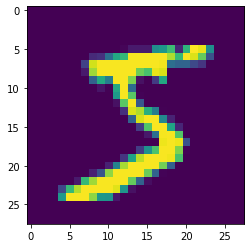

In [22]:
import matplotlib.pyplot as plt
plt.imshow(dataset1[0][0].squeeze())

In [23]:
print(dataset1[0][1])

5


In [5]:
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [25]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [29]:
def train(dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [27]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [31]:
dry_run = False
n_epochs = 14
for epoch in range(1, n_epochs + 1):
    train(dry_run, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304086
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.483454
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.553788
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.329113
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.429457
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.138165
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.138324
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.106210
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077803
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.131333
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.026926
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.044464
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.055920
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.134737
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.083895
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.211297
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.044227
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.038829
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.133101

Test set: Average loss: 0.0453, Accuracy: 9845/10000 (98%)

Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.009582
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.051869
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.149949
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.007237
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.011666
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.003852
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.042090
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.018689
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.002339
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.026952
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.004560
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.110791
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.005805
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.012774
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.019638

Test set: Average loss: 0.0272, Accuracy: 9914/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.005552
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.011325
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.106327
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.0

In [32]:
save_model = False
if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")